In [178]:
import cPickle as pickle
from sklearn.svm import SVC
import numpy as np
import caffe
import cv2
import os, sys
import subprocess
import lmdb
import matplotlib.pyplot as plt
%matplotlib inline

In [157]:
image_root = '/Users/ecsark/Documents/visualdb/project/wikiart/images/'
proj_root = '/Users/ecsark/Documents/visualdb/project/artwork-explorer/'
caffe_root = '/Users/ecsark/Documents/visualdb/caffe/'
model_weights = caffe_root + 'models/vgg/model.caffemodel'
model_def = caffe_root + 'models/vgg/deploy.prototxt'

In [158]:
label_names = []
with open("/Users/ecsark/Documents/visualdb/project/artwork-explorer/data/label.txt", 'rb') as f:
    for line in f:
        tokens = line.split(" ")[1:]
        label_names.append(" ".join(tokens))
        
n_classes = len(label_names)

In [3]:
svc = pickle.load(open(proj_root + 'model/svc_vgg_fc7.pk', 'rb'))

In [163]:
class VGGFeatureExtractor:
    def __init__(self, model_weights, model_def,
                mean=[104.0, 117.0, 123.0], 
                new_shape=(256, 256), crop=(244, 244)):
        self.net = caffe.Net(model_def, model_weights, caffe.TEST)
        self.net.blobs['data'].reshape(1, 3, 224, 224)
        self.transformer = caffe.io.Transformer({'data': self.net.blobs['data'].data.shape})
        self.transformer.set_transpose('data', (2,0,1))
        self.transformer.set_mean('data', np.array(mean))
        self.transformer.set_raw_scale('data', 255)
        self.transformer.set_channel_swap('data', (2,1,0))
        self.new_shape = new_shape
        self.crop = crop

    def reshape_image(self, image, new_dim=None, crop_dim=None):
        if new_dim is None:
            new_dim = self.new_shape
        if crop_dim is None:
            crop_dim = self.crop
        reshaped_img = cv2.resize(image, new_dim)
        crop_amt = (new_dim[0]-crop_dim[0])/2, (new_dim[1]-crop_dim[1])/2
        return reshaped_img[crop_amt[0]:crop_amt[0]+crop_dim[0], 
                            crop_amt[1]:crop_amt[1]+crop_dim[1]]

    def extract(self, image, features=['fc7'], new_dim=None, crop_dim=None):
        if new_dim is None:
            new_dim = self.new_shape
        if crop_dim is None:
            crop_dim = self.crop
        self.net.blobs['data'].data[...] = self.transformer.preprocess('data', 
                                            self.reshape_image(image, new_dim, crop_dim))
        _ = self.net.forward()
        return [self.net.blobs[ft].data[0].tolist() for ft in features]

In [145]:
class VGGFeatureExtractorCPP:
    def __init__(self, input_file, dst_image, output_dir, 
                model_def, model_weights, extract_feature_bin, feature_def):
        self.run_command = [extract_feature_bin, model_weights, model_def, feature_def, output_dir, '1', 'lmdb']
        self.output_dir = output_dir
        self.input_file = input_file
        self.dst_image = dst_image

    @staticmethod
    def read_from_db(db_dir):
        lmdb_env = lmdb.open(db_dir)
        lmdb_txn = lmdb_env.begin()
        lmdb_cursor = lmdb_txn.cursor()
        datum = caffe.proto.caffe_pb2.Datum()
        D = []
        for idx, (key, value) in enumerate(lmdb_cursor):
            datum.ParseFromString(value)
            data = caffe.io.datum_to_array(datum)
            D.append(data.flatten())

        lmdb_env.close()
        return D
    
    @staticmethod
    def execute(command):
        process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)

        # Poll process for new output until finished
        while True:
            nextline = process.stdout.readline()
            if nextline == '' and process.poll() != None:
                break
            sys.stdout.write(nextline)
            sys.stdout.flush()
            
        return process.returncode

    def extract(self, image_loc):
        with open(self.input_file, 'wb') as f:
            f.write(image_loc + " 0\n")
        subprocess.call(['rm', '-rf', self.output_dir])
        ret = self.execute(self.run_command)
        if ret == 0:
            return self.read_from_db(self.output_dir)[0]
        else:
            print "Feature extraction failed"

In [164]:
vgg = VGGFeatureExtractor(model_weights, model_def)

In [146]:
vgg_cpp = VGGFeatureExtractorCPP(proj_root+'data/input.txt', proj_root+'data/input.jpg',
                                proj_root+'data/feature_output', proj_root+'data/test.prototxt',
                                model_weights, caffe_root+'distribute/bin/extract_features.bin',
                                'fc7')

In [165]:
image = caffe.io.load_image(image_root + 'orest-kiprensky_young-gardener-1817.jpg')
fts = vgg.extract(image)

In [155]:
fts_cpp = vgg_cpp.extract(image_root + 'orest-kiprensky_young-gardener-1817.jpg')

E0406 15:23:41.483678 1980665856 extract_features.cpp:62] Using CPU
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:537] Reading dangerously large protocol message.  If the message turns out to be larger than 2147483647 bytes, parsing will be halted for security reasons.  To increase the limit (or to disable these warnings), see CodedInputStream::SetTotalBytesLimit() in google/protobuf/io/coded_stream.h.
[libprotobuf WARNING google/protobuf/io/coded_stream.cc:78] The total number of bytes read was 574671595
E0406 15:23:44.588305 1980665856 extract_features.cpp:133] Extacting Features
E0406 15:23:45.358430 1980665856 extract_features.cpp:177] Extracted features of 1 query images for feature blob fc7
E0406 15:23:45.370767 1980665856 extract_features.cpp:182] Successfully extracted the features!


In [166]:
print np.array(fts)

[[ 1.22250438  0.          0.         ...,  0.88662434  0.          0.        ]]


In [156]:
print fts_cpp

[ 0.51584476  0.          0.         ...,  0.          0.          0.        ]


In [36]:
svc.predict(fts)

array([2])

In [37]:
decisions = svc.decision_function(fts)
print decisions

[[ 0.24215921 -0.5923381  -0.06809105 -0.06195695 -0.52399939  0.07187461
   0.23932841 -0.49068354  0.15202556 -0.57688396 -0.20784036 -0.4722722
  -0.42772295 -0.17962536 -0.19215547 -0.44280365 -0.14150799  0.41118732
   0.34573998  0.02426111  0.59862412  0.59227004  0.08263467  0.59655599
  -0.17048154 -0.32821616  0.09908932  0.16658361 -0.28018347  0.15327488
  -0.21804081  0.41274482  0.46158013 -0.13253605  0.29468446  0.39056869
   0.35701922  0.02319703  0.60397657 -0.0261909  -0.38053645  0.04486848
  -0.45640103 -0.05061823  0.53064661]]


In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Comparison matrix', cmap=plt.cm.RdYlBu):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=90)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
    def get_decision(fts):
        decisions = svc.decision_function(fts)
        scores = []
        idx = 0
        for i in range(n_classes):
            i_score = []
            for j in range(i):
                i_score.append(-scores[j][i])
            i_score.append(0)
            for k in range(n_classes - i - 1):
                i_score.append(decisions[0][idx])
                idx += 1
            scores.append(i_score)
        return scores

In [33]:
def plot_confusion_matrix(scores):
    plt.figure()
    plot_confusion_matrix(scores, title='Comparison matrix')

In [82]:
def plot_bar(score1, score2):
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(label_names))
    width = 0.35
    rects1 = ax.bar(tick_marks, score1, width, color='r')
    rects2 = ax.bar(tick_marks+width, score2, width, color='b')
    #plt.bar(tick_marks, score)
    #plt.xticks(tick_marks, ['('+str(i)+')' for i, l in enumerate(label_names)])#, rotation=60)

[3]


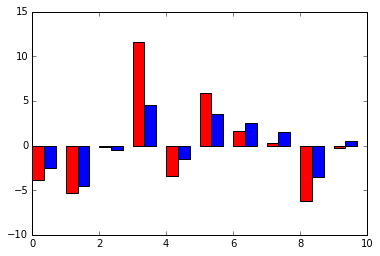

In [175]:
image = caffe.io.load_image(image_root + 'paul-cezanne_ile-de-france-landscape-1880-1.jpg')
fts = vgg.extract(image)
print svc.predict(fts)
decision = np.array(get_decision(fts))
sum_all = decision.sum(axis=1)
gt_zero = (decision>0).sum(axis=1)
plot_bar(sum_all, gt_zero-np.mean(gt_zero))

In [179]:
imagew = caffe.io.load_image('http://uploads7.wikiart.org/images/leonardo-da-vinci/mona-lisa.jpg!Large.jpg')

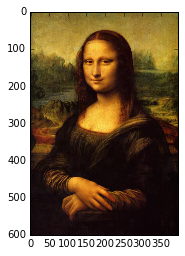

In [180]:
plt.imshow(imagew)

In [181]:
print svc.predict(vgg.extract(imagew))

[1]
